In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=7, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.Resnet18 = resnet18()
        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(10,50)
        self.fc2 = nn.Linear(50,7)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = F.dropout(xs)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
       
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
   
        return x

    def forward(self,input):
        out = self.stn(input)
        out = self.Resnet18(out)
        # out = F.dropout(out)
        # out = F.relu(self.fc1(out))
        # out = self.fc2(out)
        
        return out

In [6]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

## 48 x 48 , 2304  1d dimension , save it in .csv file along with labels 
class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, test_filename = 'finaltest_q', val_filename= 'val_q'):
        """
        Helper function to split the validation and test data from general test file as it contains (Public test, Private test)
            params:-
                data_path = path to the folder that contains the test data file
        """
        csv_path = self.data_path +"/"+ 'test.csv'
        test = pd.read_csv(csv_path)
        validation_data = pd.DataFrame(test.iloc[:3589,:])
        test_data = pd.DataFrame(test.iloc[3589:,:])
        test_data.to_csv(self.data_path+"/"+test_filename+".csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, finaltest)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))

In [7]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

## 48 x 48 , 2304  1d dimension , save it in .csv file along with labels 
class Generate_data():
    def __init__(self, datapath):
        """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_images
        [Note] that you have to split the public and private from fer2013 file
        """
        self.data_path = datapath

    def split_test(self, test_filename = 'finaltest_ck', val_filename= 'val_ck'):
        """
        Helper function to split the validation and test data from general test file as it contains (Public test, Private test)
            params:-
                data_path = path to the folder that contains the test data file
        """
        csv_path = self.data_path +"/"+ 'ck2021.csv'
        test = pd.read_csv(csv_path)
        validation_data = pd.DataFrame(test.iloc[:600,:])
        test_data = pd.DataFrame(test.iloc[600:,:])
        test_data.to_csv(self.data_path+"/"+test_filename+".csv")
        validation_data.to_csv(self.data_path+"/"+val_filename+".csv")
        print("Done splitting the test file into validation & final test file")

    def str_to_image(self, str_img = ' '):
        '''
        Convert string pixels from the csv file into image object
            params:- take an image string
            return :- return PIL image object
        '''
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str,dtype=np.uint8).reshape(48,48)
        return Image.fromarray(imgarray)

    def save_images(self, datatype='train'):
        '''
        save_images is a function responsible for saving images from data files e.g(train, test) in a desired folder
            params:-
            datatype= str e.g (train, val, finaltest)
        '''
        foldername= self.data_path+"/"+datatype
        csvfile_path= self.data_path+"/"+datatype+'.csv'
        if not os.path.exists(foldername):
            os.mkdir(foldername)

        data = pd.read_csv(csvfile_path)
        images = data['pixels'] #dataframe to series pandas
        numberofimages = images.shape[0]
        for index in tqdm(range(numberofimages)):
            img = self.str_to_image(images[index])
            img.save(os.path.join(foldername,'{}{}.jpg'.format(datatype,index)),'JPEG')
        print('Done saving {} data'.format((foldername)))

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

#Helper function
def eval_data_dataloader(csv_file,img_dir,datatype,sample_number,transform= None):
    '''
    Helper function used to evaluate the Dataset class
    params:-
            csv_file : the path of the csv file    (train, validation, test)
            img_dir  : the directory of the images (train, validation, test)
            datatype : string for searching along the image_dir (train, val, test)
            sample_number : any number from the data to be shown
    '''
    if transform is None :
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
    dataset = Plain_Dataset(csv_file=csv_file,img_dir = img_dir,datatype = datatype,transform = transform)

    label = dataset.__getitem__(sample_number)[1]
    print(label)
    imgg = dataset.__getitem__(sample_number)[0]
    imgnumpy = imgg.numpy()
    imgt = imgnumpy.squeeze()
    plt.imshow(imgt)
    plt.show()

In [14]:

generate_dataset = Generate_data("C:/Users/1315/OneDrive - 계명대학교/지은이/학교/대학원/연구/IPIU/DeepEmotion/data")
generate_dataset.split_test()
generate_dataset.save_images()
generate_dataset.save_images('finaltest_q')
generate_dataset.save_images('val_q')

Done splitting the test file into validation & final test file


100%|██████████| 28709/28709 [00:25<00:00, 1136.27it/s]


Done saving C:/Users/1315/OneDrive - 계명대학교/지은이/학교/대학원/연구/IPIU/DeepEmotion/data/train data


100%|██████████| 3589/3589 [00:03<00:00, 1000.38it/s]


Done saving C:/Users/1315/OneDrive - 계명대학교/지은이/학교/대학원/연구/IPIU/DeepEmotion/data/finaltest_q data


100%|██████████| 3589/3589 [00:03<00:00, 1047.69it/s]

Done saving C:/Users/1315/OneDrive - 계명대학교/지은이/학교/대학원/연구/IPIU/DeepEmotion/data/val_q data


In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1-x2).pow(2).sum(1) 
    
    def forward(self,  anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [9]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#from data_loaders import Plain_Dataset, eval_data_dataloader
#from deep_emotion import Deep_Emotion
#from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val_losses_list = []
train_losses_list = []

val_acc_list = []
train_acc_list = []


def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)


        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)

        train_losses_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_losses_list.append(validation_loss)
        val_acc_list.append(val_acc)

        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


epochs = 100
lr = 0.001
batchsize = 8

net = Deep_Emotion()
net.to(device)
from torchsummary import summary
summary(net, input_size=(1, 48, 48))
traincsv_file = 'data'+'/'+'train.csv'
valcsv_file = 'data'+'/'+'val_q.csv'
train_img_dir = 'data'+'/'+'train/'
val_img_dir = 'data'+'/'+'val_q/'

transformation = transforms.Compose([transforms.ToTensor()])
train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'train',transform = transformation )
val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'val_q',transform = transformation )
train_loader = DataLoader(train_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
#criterion= nn.CrossEntropyLoss()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optmizer= optim.Adam(net.parameters(),lr= lr)

print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(val_dataset)}")

#Train(epochs, train_loader, val_loader, criterion, optmizer, device) 

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = net(data)
        loss = criterion(output, label)

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            val_losses_list.append(epoch_val_loss.item())
            val_acc_list.append(epoch_val_accuracy.item())
        

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses_list,label="val")
plt.plot(train_losses_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation acc")
plt.plot(val_acc_list,label="val")
plt.plot(train_acc_list,label="train")
plt.xlabel("iterations")
plt.ylabel("acc")
plt.legend()
plt.show()



C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]             400
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 64, 24, 24]           3,136
      BatchNorm2d-11           [-1, 64, 24, 24]             128
             ReLU-12           [-1, 64, 24, 24]               0
        MaxPool2d-13           [-1, 64, 12, 12]               0
           Conv2d-14           [-1, 64,

  0%|          | 0/3589 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'negative'

torch.Size([8, 1, 48, 48])


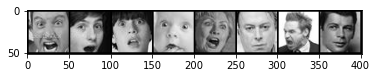

GroundTruth:   Fear Surprise Fear Surprise Angry Angry Angry Neutral
Predicted:   Fear Surprise Surprise Surprise Angry Fear Angry Angry


In [25]:
torch.save(net.state_dict(),'MyEmotion_train_fer.pt')
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ''.join(' %s' % classes[labels[j]] for j in range(8)))

net = Deep_Emotion()
net.load_state_dict(torch.load('MyEmotion_train_fer.pt'))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ''.join(' %s' % classes[predicted[j]]for j in range(8)))





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           3,136
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

100%|██████████| 75/75 [00:01<00:00, 53.19it/s]


Epoch : 1 - loss : 1.3235 - acc: 0.5050 - val_loss : 0.8839 - val_acc: 0.6620



100%|██████████| 75/75 [00:01<00:00, 54.57it/s]


Epoch : 2 - loss : 0.7853 - acc: 0.7017 - val_loss : 0.9284 - val_acc: 0.6703



100%|██████████| 75/75 [00:01<00:00, 54.64it/s]


Epoch : 3 - loss : 0.7195 - acc: 0.7517 - val_loss : 0.7321 - val_acc: 0.7458



100%|██████████| 75/75 [00:01<00:00, 53.99it/s]


Epoch : 4 - loss : 0.5328 - acc: 0.8000 - val_loss : 0.3863 - val_acc: 0.8542



100%|██████████| 75/75 [00:01<00:00, 54.60it/s]


Epoch : 5 - loss : 0.3853 - acc: 0.8717 - val_loss : 0.3183 - val_acc: 0.9167



100%|██████████| 75/75 [00:01<00:00, 54.38it/s]


Epoch : 6 - loss : 0.2352 - acc: 0.9300 - val_loss : 0.3506 - val_acc: 0.8786



100%|██████████| 75/75 [00:01<00:00, 53.87it/s]


Epoch : 7 - loss : 0.1416 - acc: 0.9600 - val_loss : 0.3106 - val_acc: 0.9255



100%|██████████| 75/75 [00:01<00:00, 53.22it/s]


Epoch : 8 - loss : 0.1635 - acc: 0.9400 - val_loss : 0.4148 - val_acc: 0.8724



100%|██████████| 75/75 [00:01<00:00, 53.18it/s]


Epoch : 9 - loss : 0.2259 - acc: 0.9333 - val_loss : 0.3667 - val_acc: 0.8786



100%|██████████| 75/75 [00:01<00:00, 53.01it/s]


Epoch : 10 - loss : 0.1767 - acc: 0.9433 - val_loss : 0.2570 - val_acc: 0.9193



100%|██████████| 75/75 [00:01<00:00, 53.26it/s]


Epoch : 11 - loss : 0.1098 - acc: 0.9700 - val_loss : 0.2615 - val_acc: 0.9193



100%|██████████| 75/75 [00:01<00:00, 54.07it/s]


Epoch : 12 - loss : 0.0907 - acc: 0.9733 - val_loss : 0.2794 - val_acc: 0.9297



100%|██████████| 75/75 [00:01<00:00, 53.84it/s]


Epoch : 13 - loss : 0.1554 - acc: 0.9617 - val_loss : 0.2846 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 52.26it/s]


Epoch : 14 - loss : 0.0890 - acc: 0.9717 - val_loss : 0.2388 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 53.07it/s]


Epoch : 15 - loss : 0.0445 - acc: 0.9883 - val_loss : 0.2114 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 53.79it/s]


Epoch : 16 - loss : 0.0307 - acc: 0.9917 - val_loss : 0.1968 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 53.72it/s]


Epoch : 17 - loss : 0.0506 - acc: 0.9833 - val_loss : 0.2457 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 53.80it/s]


Epoch : 18 - loss : 0.0360 - acc: 0.9900 - val_loss : 0.1512 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.68it/s]


Epoch : 19 - loss : 0.0336 - acc: 0.9900 - val_loss : 0.1956 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.75it/s]


Epoch : 20 - loss : 0.0424 - acc: 0.9900 - val_loss : 0.1896 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 53.81it/s]


Epoch : 21 - loss : 0.0323 - acc: 0.9900 - val_loss : 0.4021 - val_acc: 0.9099



100%|██████████| 75/75 [00:01<00:00, 54.07it/s]


Epoch : 22 - loss : 0.1437 - acc: 0.9633 - val_loss : 0.2332 - val_acc: 0.9349



100%|██████████| 75/75 [00:01<00:00, 53.79it/s]


Epoch : 23 - loss : 0.0208 - acc: 0.9967 - val_loss : 0.1150 - val_acc: 0.9609



100%|██████████| 75/75 [00:01<00:00, 53.65it/s]


Epoch : 24 - loss : 0.0071 - acc: 0.9983 - val_loss : 0.1971 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.71it/s]


Epoch : 25 - loss : 0.0034 - acc: 1.0000 - val_loss : 0.1459 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 53.52it/s]


Epoch : 26 - loss : 0.0030 - acc: 1.0000 - val_loss : 0.1777 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 53.71it/s]


Epoch : 27 - loss : 0.0012 - acc: 1.0000 - val_loss : 0.1816 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 53.15it/s]


Epoch : 28 - loss : 0.0009 - acc: 1.0000 - val_loss : 0.1782 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 53.98it/s]


Epoch : 29 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.1861 - val_acc: 0.9594



100%|██████████| 75/75 [00:01<00:00, 54.45it/s]


Epoch : 30 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.1828 - val_acc: 0.9635



100%|██████████| 75/75 [00:01<00:00, 54.19it/s]


Epoch : 31 - loss : 0.0006 - acc: 1.0000 - val_loss : 0.1884 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 53.79it/s]


Epoch : 32 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.1817 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 53.90it/s]


Epoch : 33 - loss : 0.0839 - acc: 0.9867 - val_loss : 0.6798 - val_acc: 0.7823



100%|██████████| 75/75 [00:01<00:00, 54.44it/s]


Epoch : 34 - loss : 0.2793 - acc: 0.9217 - val_loss : 0.3815 - val_acc: 0.9099



100%|██████████| 75/75 [00:01<00:00, 54.65it/s]


Epoch : 35 - loss : 0.0794 - acc: 0.9800 - val_loss : 0.1926 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 53.68it/s]


Epoch : 36 - loss : 0.0781 - acc: 0.9767 - val_loss : 0.2732 - val_acc: 0.9193



100%|██████████| 75/75 [00:01<00:00, 54.29it/s]


Epoch : 37 - loss : 0.1016 - acc: 0.9733 - val_loss : 0.2405 - val_acc: 0.9349



100%|██████████| 75/75 [00:01<00:00, 54.02it/s]


Epoch : 38 - loss : 0.0144 - acc: 0.9950 - val_loss : 0.1966 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 54.42it/s]


Epoch : 39 - loss : 0.1215 - acc: 0.9633 - val_loss : 0.1638 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 54.53it/s]


Epoch : 40 - loss : 0.1329 - acc: 0.9650 - val_loss : 0.1899 - val_acc: 0.9375



100%|██████████| 75/75 [00:01<00:00, 54.73it/s]


Epoch : 41 - loss : 0.0189 - acc: 0.9950 - val_loss : 0.2589 - val_acc: 0.9318



100%|██████████| 75/75 [00:01<00:00, 54.22it/s]


Epoch : 42 - loss : 0.0134 - acc: 0.9950 - val_loss : 0.2799 - val_acc: 0.9349



100%|██████████| 75/75 [00:01<00:00, 53.78it/s]


Epoch : 43 - loss : 0.0051 - acc: 0.9983 - val_loss : 0.2070 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 54.33it/s]


Epoch : 44 - loss : 0.0013 - acc: 1.0000 - val_loss : 0.2149 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 54.27it/s]


Epoch : 45 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.1858 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 54.01it/s]


Epoch : 46 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.2153 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 54.18it/s]


Epoch : 47 - loss : 0.0007 - acc: 1.0000 - val_loss : 0.2471 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 54.06it/s]


Epoch : 48 - loss : 0.0010 - acc: 1.0000 - val_loss : 0.2056 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 53.60it/s]


Epoch : 49 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.2549 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.85it/s]


Epoch : 50 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.2182 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.95it/s]


Epoch : 51 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2086 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 54.07it/s]


Epoch : 52 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2200 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 54.29it/s]


Epoch : 53 - loss : 0.0004 - acc: 1.0000 - val_loss : 0.2172 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.00it/s]


Epoch : 54 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2494 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.77it/s]


Epoch : 55 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2292 - val_acc: 0.9453



100%|██████████| 75/75 [00:01<00:00, 53.73it/s]


Epoch : 56 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2429 - val_acc: 0.9500



100%|██████████| 75/75 [00:01<00:00, 53.68it/s]


Epoch : 57 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.3199 - val_acc: 0.9401



100%|██████████| 75/75 [00:01<00:00, 53.75it/s]


Epoch : 58 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.2472 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 53.41it/s]


Epoch : 59 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.2466 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.75it/s]


Epoch : 60 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2285 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 53.75it/s]


Epoch : 61 - loss : 0.0003 - acc: 1.0000 - val_loss : 0.2280 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.68it/s]


Epoch : 62 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2511 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 53.82it/s]


Epoch : 63 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2309 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 53.75it/s]


Epoch : 64 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1928 - val_acc: 0.9542



100%|██████████| 75/75 [00:01<00:00, 53.99it/s]


Epoch : 65 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2640 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.83it/s]


Epoch : 66 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2744 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 53.03it/s]


Epoch : 67 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1794 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.20it/s]


Epoch : 68 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2347 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.41it/s]


Epoch : 69 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2805 - val_acc: 0.9453



100%|██████████| 75/75 [00:01<00:00, 53.42it/s]


Epoch : 70 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2188 - val_acc: 0.9490



100%|██████████| 75/75 [00:01<00:00, 53.21it/s]


Epoch : 71 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2613 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 53.03it/s]


Epoch : 72 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2821 - val_acc: 0.9437



100%|██████████| 75/75 [00:01<00:00, 54.20it/s]


Epoch : 73 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2821 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 55.25it/s]


Epoch : 74 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2462 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 55.42it/s]


Epoch : 75 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2537 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 55.86it/s]


Epoch : 76 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2587 - val_acc: 0.9453



100%|██████████| 75/75 [00:01<00:00, 55.91it/s]


Epoch : 77 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2771 - val_acc: 0.9490



100%|██████████| 75/75 [00:01<00:00, 54.85it/s]


Epoch : 78 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2573 - val_acc: 0.9505



100%|██████████| 75/75 [00:01<00:00, 54.65it/s]


Epoch : 79 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.1983 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 54.77it/s]


Epoch : 80 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2540 - val_acc: 0.9609



100%|██████████| 75/75 [00:01<00:00, 54.57it/s]


Epoch : 81 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2354 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 54.89it/s]


Epoch : 82 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2801 - val_acc: 0.9557



100%|██████████| 75/75 [00:01<00:00, 55.17it/s]


Epoch : 83 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2576 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 55.21it/s]


Epoch : 84 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3251 - val_acc: 0.9411



100%|██████████| 75/75 [00:01<00:00, 55.46it/s]


Epoch : 85 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2226 - val_acc: 0.9583



100%|██████████| 75/75 [00:01<00:00, 55.60it/s]


Epoch : 86 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.2466 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 54.33it/s]


Epoch : 87 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2875 - val_acc: 0.9427



100%|██████████| 75/75 [00:01<00:00, 53.16it/s]


Epoch : 88 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2404 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.93it/s]


Epoch : 89 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2892 - val_acc: 0.9464



100%|██████████| 75/75 [00:01<00:00, 54.81it/s]


Epoch : 90 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2862 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 54.97it/s]


Epoch : 91 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2470 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 55.05it/s]


Epoch : 92 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.3071 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 53.34it/s]


Epoch : 93 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2840 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 54.81it/s]


Epoch : 94 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.3058 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 54.86it/s]


Epoch : 95 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2893 - val_acc: 0.9464



100%|██████████| 75/75 [00:01<00:00, 53.27it/s]


Epoch : 96 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.3441 - val_acc: 0.9464



100%|██████████| 75/75 [00:01<00:00, 54.18it/s]


Epoch : 97 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2431 - val_acc: 0.9531



100%|██████████| 75/75 [00:01<00:00, 53.22it/s]


Epoch : 98 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2933 - val_acc: 0.9453



100%|██████████| 75/75 [00:01<00:00, 54.51it/s]


Epoch : 99 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.2895 - val_acc: 0.9479



100%|██████████| 75/75 [00:01<00:00, 54.89it/s]


Epoch : 100 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.3298 - val_acc: 0.9479



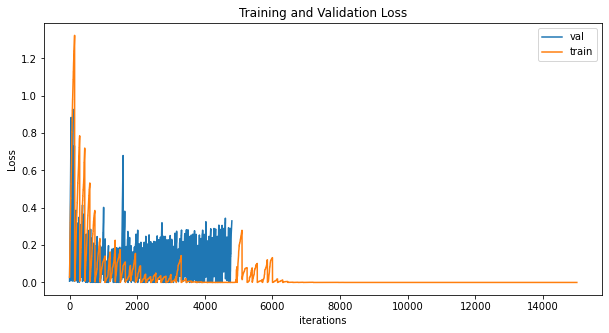

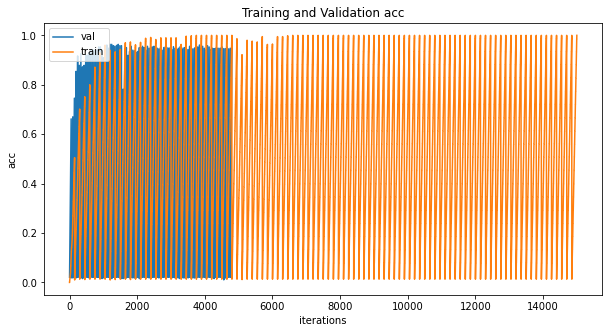

In [29]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

#from data_loaders import Plain_Dataset, eval_data_dataloader
#from deep_emotion import Deep_Emotion
#from generate_data import Generate_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

val_losses_list = []
train_losses_list = []

val_acc_list = []
train_acc_list = []


def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)


        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)

        train_losses_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_losses_list.append(validation_loss)
        val_acc_list.append(val_acc)

        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")


epochs = 100
lr = 0.001
batchsize = 8

net = Deep_Emotion()
net.to(device)
from torchsummary import summary
summary(net, input_size=(1, 48, 48))
traincsv_file = 'data'+'/'+'val_ck.csv'
valcsv_file = 'data'+'/'+'finaltest_ck.csv'

train_img_dir = 'data'+'/'+'val_ck/'
val_img_dir = 'data'+'/'+'finaltest_ck/'

transformation = transforms.Compose([transforms.ToTensor()])
train_dataset = Plain_Dataset(csv_file = traincsv_file, img_dir = train_img_dir, datatype = 'val_ck',transform = transformation )
val_dataset = Plain_Dataset(csv_file = valcsv_file, img_dir = val_img_dir, datatype = 'finaltest_ck',transform = transformation )
train_loader = DataLoader(train_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
val_loader = DataLoader(val_dataset,batch_size=batchsize, shuffle = True, num_workers=0)
criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(net.parameters(),lr= lr)

print(f"Train Data: {len(train_dataset)}")
print(f"Test Data: {len(val_dataset)}")

#Train(epochs, train_loader, val_loader, criterion, optmizer, device) 

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = net(data)
        loss = criterion(output, label)

        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())
        train_losses_list.append(epoch_loss.item())
        train_acc_list.append(epoch_accuracy.item())

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = net(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            val_losses_list.append(epoch_val_loss.item())
            val_acc_list.append(epoch_val_accuracy.item())
        

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses_list,label="val")
plt.plot(train_losses_list,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation acc")
plt.plot(val_acc_list,label="val")
plt.plot(train_acc_list,label="train")
plt.xlabel("iterations")
plt.ylabel("acc")
plt.legend()
plt.show()



In [ ]:
torch.save(net.state_dict(),'MyEmotion_train_ck.pt')

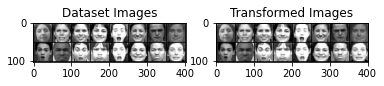

In [ ]:
from __future__ import print_function
device = 'cuda'
model = Deep_Emotion().to(device)
model.load_state_dict(torch.load('MyEmotion_train_ck.pt'))

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Grayscale(),
     
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Grayscale(),
        
    ]
)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(val_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')




visualize_stn()   

torch.Size([8, 1, 48, 48])


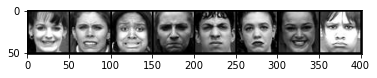

GroundTruth:   Happy Fear Fear Angry Disgust Surprise Happy Surprise
Predicted:   Happy Fear Happy Angry Disgust Surprise Happy Surprise


In [12]:
torch.save(net.state_dict(),'MyEmotion_train_ck.pt')
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes=['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
dataiter = iter(val_loader)
images,labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ''.join(' %s' % classes[labels[j]] for j in range(8)))

net = Deep_Emotion()
net.load_state_dict(torch.load('MyEmotion_train_ck.pt'))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ''.join(' %s' % classes[predicted[j]]for j in range(8)))





In [ ]:
net = Deep_Emotion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load('MyEmotion_train6.pt'))
net.to(device)
print(net)

Deep_Emotion(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Resnet34): ResNet(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (conv2_x): Sequential(
      (0): BasicBlock(
        (residual_function): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
import cv2 
import matplotlib.pyplot as plt

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [ ]:
frame = cv2.imread('train14.jpg')

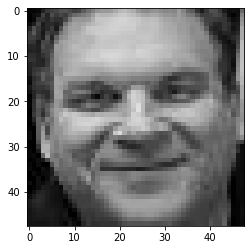

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [ ]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray=gray[y:y+h,x:x+w]
    roi_color = frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    facess = faceCascade.detectMultiScale(roi_color)
    if len(facess) == 0:
        print("Face not detected")
    else:
        for(ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey:ey+eh,ex:ex+ew]

Face not detected


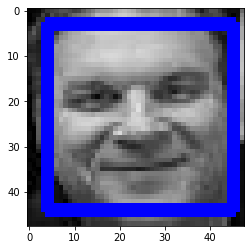

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(face_roi)

NameError: name 'face_roi' is not defined

In [ ]:
gray=cv2.cvtColor(face_roi,cv2.COLOR_BGR2GRAY)

NameError: name 'face_roi' is not defined

In [ ]:
gray.shape

(48, 48)

In [ ]:
final_image = cv2.resize(gray,(48,48))

In [ ]:
final_image.shape

(48, 48)

In [ ]:
final_image = np.expand_dims(final_image,axis=0)

In [ ]:
final_image.shape

(1, 1, 48, 48)

In [ ]:
final_image=final_image/255.0 ##normalization 

In [ ]:
dataa = torch.from_numpy(final_image)

In [ ]:
dataa=dataa.type(torch.FloatTensor)

Fear


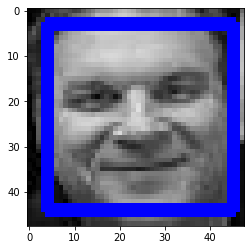

In [ ]:

dataa=dataa.type(torch.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataa=dataa.to(device)
outputs = net(dataa)
pred = F.softmax(outputs,dim=1)

classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

print(classes[torch.argmax(pred)])
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))


In [ ]:
outputs = net(dataa)
pred = F.softmax(outputs,dim=1)

C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\1315\anaconda3\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [ ]:
print(pred)

tensor([[1.6437e-02, 9.6138e-05, 2.4391e-03, 5.2928e-01, 2.9537e-03, 7.4969e-03,
         4.4129e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)


Happy


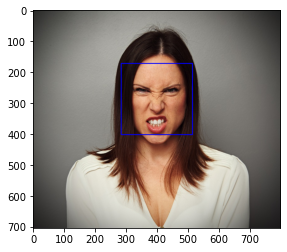

In [ ]:
classes = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

print(classes[torch.argmax(pred)])
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))